In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
from scipy import stats
from cooltools.lib import numutils

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
import warnings

# Suppress specific PerformanceWarning from pandas
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
from akita_utils.analysis_utils import split_by_percentile_groups

import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import read_multi_model_data

2024-07-05 19:43:35.233121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 19:43:35.233174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 19:43:35.308413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 19:43:35.352504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 19:43:38.264305: W tensorflow/compiler/tf2

In [4]:
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_number"

In [5]:
df = read_multi_model_data(data_dir, keys_to_ignore = ["disruption_SCD", "insertion_SCD"])

Model:  0
	 - bg: 1
	 - bg: 2
	 - bg: 3
	 - bg: 4
	 - bg: 5
	 - bg: 6
	 - bg: 7
	 - bg: 8
	 - bg: 9
Model:  1
	 - bg: 0
	 - bg: 1
	 - bg: 2
	 - bg: 3
	 - bg: 4
	 - bg: 5
	 - bg: 6
	 - bg: 7
	 - bg: 8
	 - bg: 9
Model:  2
	 - bg: 0
	 - bg: 1
	 - bg: 2
	 - bg: 3
	 - bg: 4
	 - bg: 5
	 - bg: 6
	 - bg: 7
	 - bg: 8
	 - bg: 9
Model:  3
	 - bg: 0
	 - bg: 1
	 - bg: 2
	 - bg: 3
	 - bg: 4
	 - bg: 5
	 - bg: 6
	 - bg: 7
	 - bg: 8
	 - bg: 9


In [6]:
for model_index in range(2):
    for background_index_0 in range(3):
        for background_index_1 in range(3):
            if background_index_0 > background_index_1:
                print("Model", model_index)
                print("\t - Correlation between backgrounds: ", background_index_0, background_index_1)
                perm_corr = round(stats.pearsonr(df[f"SCD_m0_bg{background_index_0}"], df[f"SCD_m0_bg{background_index_1}"]).statistic, 4)
                print("\t", perm_corr)

Model 0
	 - Correlation between backgrounds:  1 0
	 0.998
Model 0
	 - Correlation between backgrounds:  2 0
	 0.9946
Model 0
	 - Correlation between backgrounds:  2 1
	 0.9928
Model 1
	 - Correlation between backgrounds:  1 0
	 0.998
Model 1
	 - Correlation between backgrounds:  2 0
	 0.9946
Model 1
	 - Correlation between backgrounds:  2 1
	 0.9928


In [7]:
def get_num_sites(row):
    return len(row["orientation"])

In [8]:
df["number"] = df.apply(get_num_sites, axis=1)

In [9]:
df_sorted = df.sort_values(by='insertion_SCD').reset_index(drop=True)

In [10]:
df_sorted.loc[:249, 'insSCD_group'] = 'Group_0'

In [11]:
total_rows = len(df_sorted) - 250
rows_per_group = total_rows // 4

In [12]:
for i, group in enumerate(['Group_1', 'Group_2', 'Group_3', 'Group_4'], start=1):
    start_idx = 250 + (i - 1) * rows_per_group
    end_idx = start_idx + rows_per_group
    df_sorted.loc[start_idx:end_idx, 'insSCD_group'] = group

In [13]:
df_sorted.loc[250 + 3 * rows_per_group:, 'insSCD_group'] = 'Group_4'

In [ ]:
# df_sorted

In [ ]:
# df_split_SCDins = split_by_percentile_groups(df, column_to_split="insertion_SCD", num_classes=8, 
#                                upper_percentile=100, lower_percentile=0, 
#                                category_colname="insSCD_group")

In [14]:
# number_df = df_split_SCDins.groupby(["insSCD_group", "number"]).agg({"SCD": "mean"}).reset_index()

number_df = df_sorted.groupby(["insSCD_group", "number"]).agg({"SCD": "mean"}).reset_index()

In [15]:
color_dict = {"Group_0": "#9fc2e0",
              "Group_1": "#6da3d0",
              "Group_2":"#3b7fb9", 
              "Group_3":"#2d618e", 
              "Group_4":"#1d3f5c"}

In [16]:
max_num_sites = 40

## Plot with sites splited into 5 groups by percentiles

Text(0, 0.5, 'Insertion SCD')

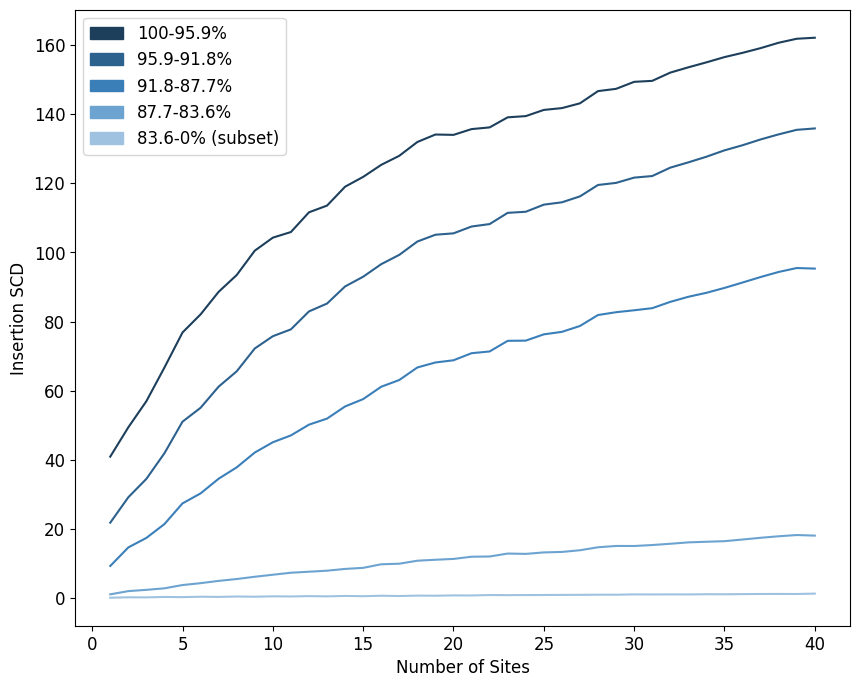

In [17]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, number_df[(number_df["insSCD_group"] == group)]["SCD"], 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="83.6-0% (subset)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")

## Plot with smoothed lines

In [18]:
bin_size = 11

Text(0, 0.5, 'Insertion SCD')

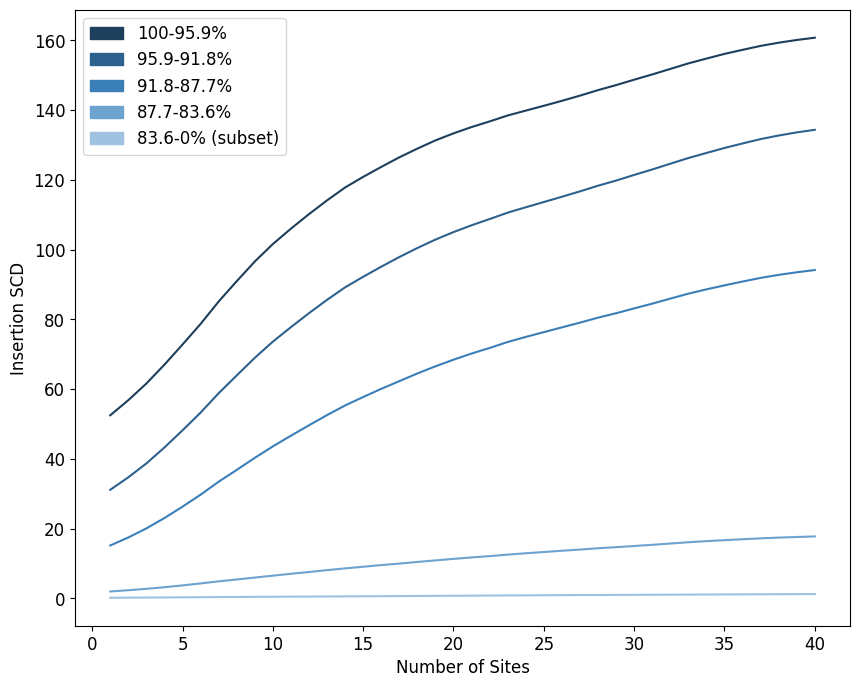

In [19]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size), 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="83.6-0% (subset)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")

## Plot with smoothed lines and 25-75 percentile bands

In [20]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [21]:
insSCDpercentiles_df = df_sorted.groupby(["insSCD_group", "number"])["SCD"].agg(
    percentile25 = percentile(25), percentile75 = percentile(75)).reset_index()

Text(0, 0.5, 'Insertion SCD')

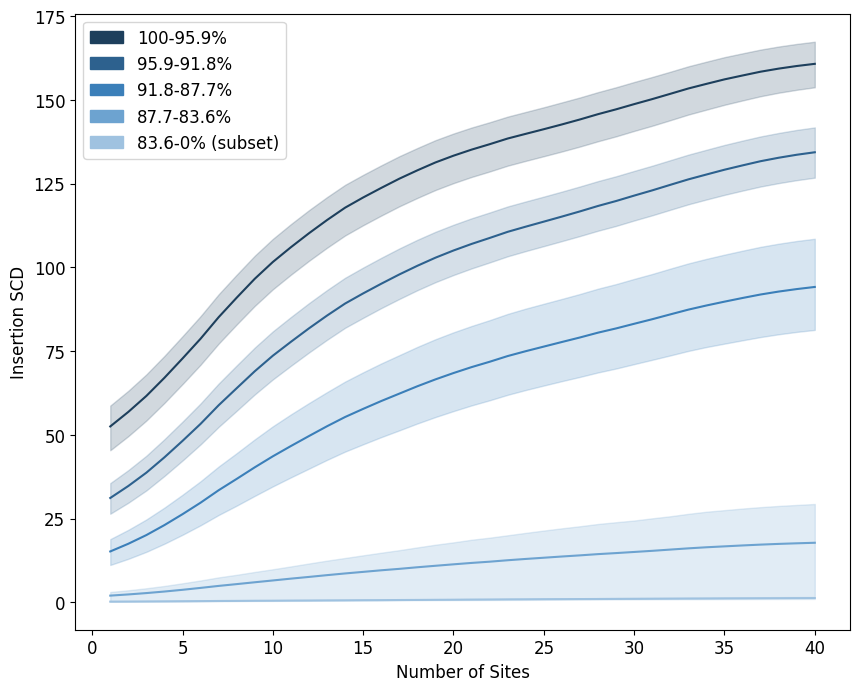

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    # if group != "Group_1":
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="83.6-0% (subset)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")

## Plotting up to 10 sites (1 bin)

Text(0, 0.5, 'Insertion SCD')

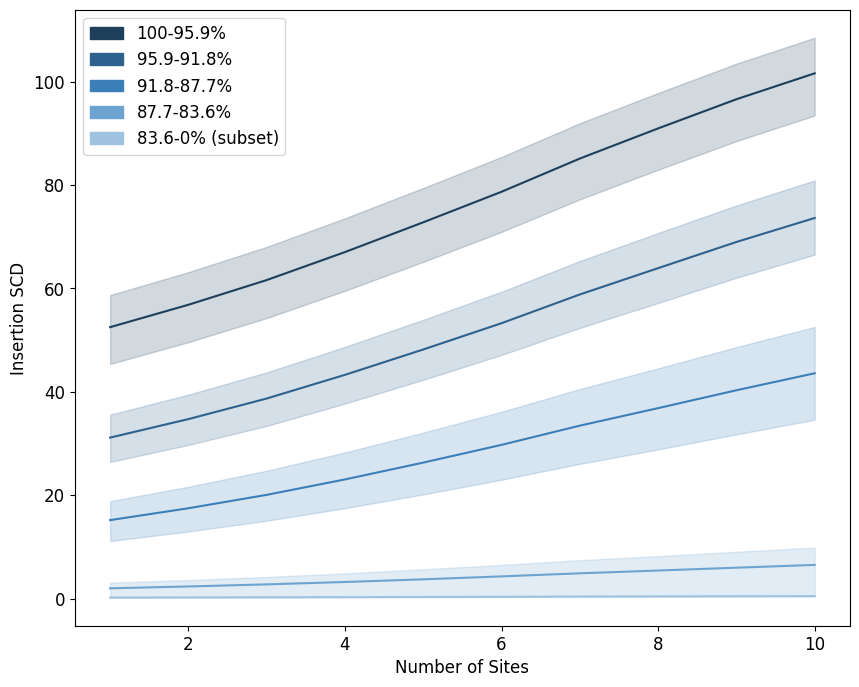

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1, 10+1)]

for group in number_df.insSCD_group.unique():
    # if group != "Group_1":
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size)[:10],
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)[:10]
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)[:10]

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="83.6-0% (subset)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")

## Plotting 10 random sites from high, medium, low insertion_SCD group

In [26]:
num_sites = 10
ten_high = np.random.choice(df_sorted[df_sorted["insSCD_group"] == "Group_4"].start.unique(), size=num_sites)
ten_medium = np.random.choice(df_sorted[df_sorted["insSCD_group"] == "Group_2"].start.unique(), size=num_sites)
ten_low = np.random.choice(df_sorted[df_sorted["insSCD_group"] == "Group_0"].start.unique(), size=num_sites)

Text(0, 0.5, 'Insertion SCD')

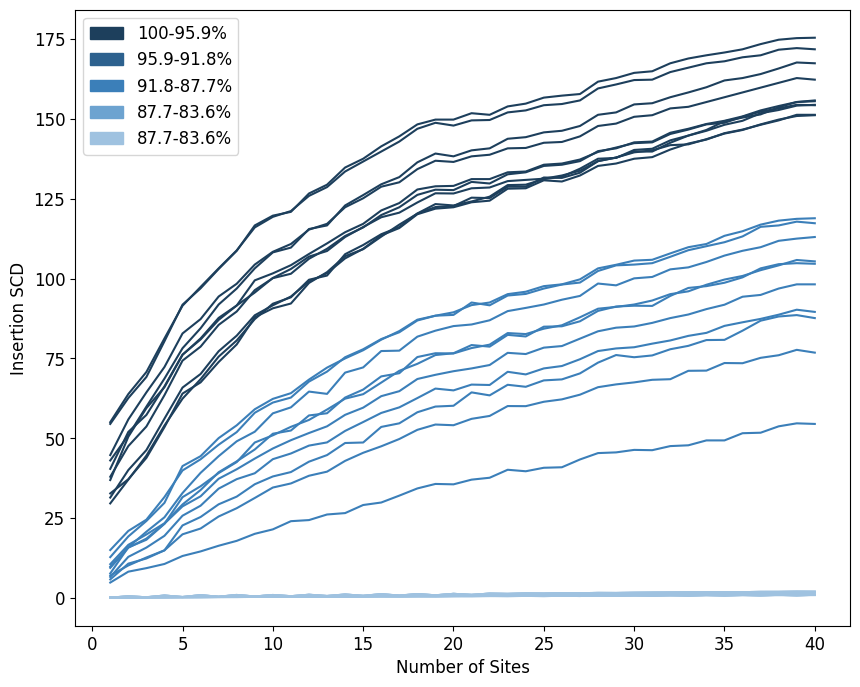

In [27]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for start_pos in ten_high:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#1d3f5c")

for start_pos in ten_medium:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#3b7fb9")

for start_pos in ten_low:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#9fc2e0")

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="87.7-83.6%")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# # plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")

## Plot with smoothed trends of 5 classes overlayed with 10 lines randomly chosen from the 'High'

Text(0, 0.5, 'Insertion Score')

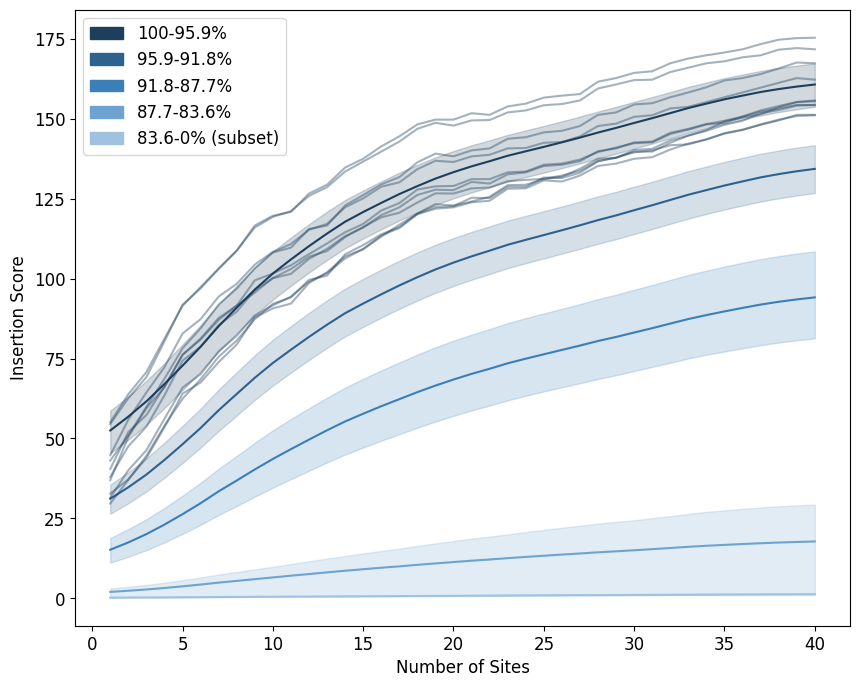

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="83.6-0% (subset)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

# plt.savefig("./plots/insertion_score_vs_sites_number.pdf", format="pdf", bbox_inches="tight")


## Plot for up to 10 sites

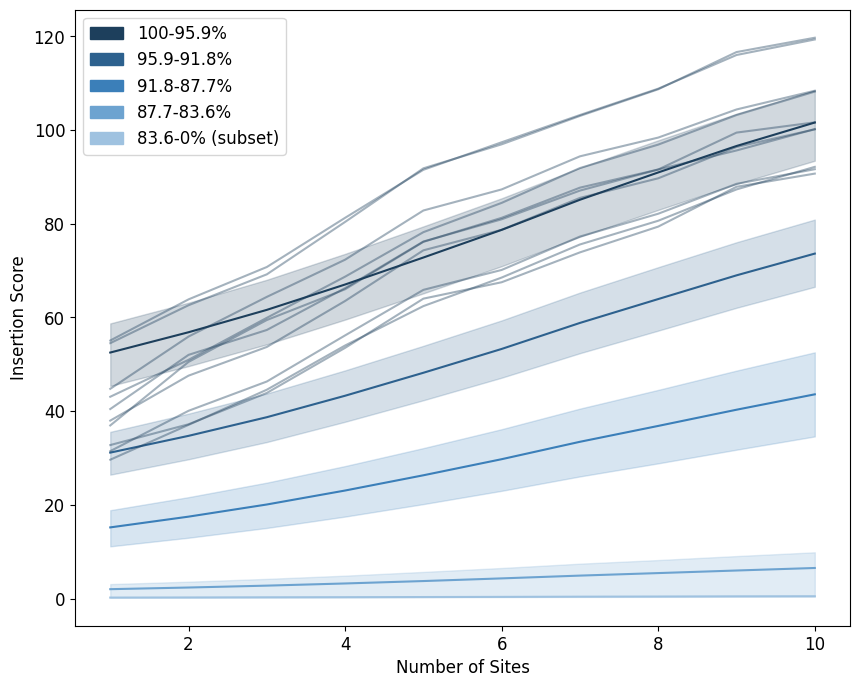

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1,10+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size)[:10],
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)[:10]
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)[:10]

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"][:10], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="83.6-0% (subset)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

plt.savefig("./plots/insertion_score_vs_sites_number_up10.pdf", format="pdf", bbox_inches="tight")